# Testing - Event Tracking in Time:

If we follow the hobday definition heatwaves should only be labeled as events if they persist for 5 days or more and experience breaks of no more than two days. These criteria will need to use the boolean flags of whether a temperature exceeds the HW/CS threshold or not using a moving window to track events.

This notebook tests different ways to try and track those events and how efficiently each can be done.

In [1]:
# Libraries
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import oisstools as ot
 
# Set Notebook Options:  -----------------------------------
box_root = ot.set_workspace("local")

# Confirm and Report what options are selected -------------
print(f"Working via directory at: {box_root}")

Working via directory at: /Users/akemberling/Library/CloudStorage/Box-Box/


In [2]:
# From another notebook we have saved all the cased where temperatures are above a detrended threshold:
# NB = "TESTING_detrended_GOM_HW"

# Those events have been saved here:
events_ds = xr.open_dataset(f"{box_root}/RES_Data/OISST/oisst_mainstays/mhw_thresholds/1991to2020_mhw_events.nc")
events_ds

<xarray.Dataset>
Dimensions:  (time: 14975, lat: 26, lon: 56)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2022-12-31T12:00:00
  * lat      (lat) float32 39.12 39.38 39.62 39.88 ... 44.62 44.88 45.12 45.38
  * lon      (lon) float32 285.6 285.9 286.1 286.4 ... 298.6 298.9 299.1 299.4
    doy      (time) int64 ...
Data variables:
    sst      (time, lat, lon) float32 ...
    is_hw    (time, lat, lon) bool ...
    is_cs    (time, lat, lon) bool ...
Attributes:
    Conventions:    CF-1.5
    title:          NOAA High-resolution Blended Analysis: Daily Values using...
    institution:    NOAA/NCDC
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    comment:        Reynolds, et al., 2007: Daily High-Resolution-Blended Ana...
    history:        Thu Aug 24 13:35:47 2017: ncatted -O -a References,global...
    references:     https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oiss...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature

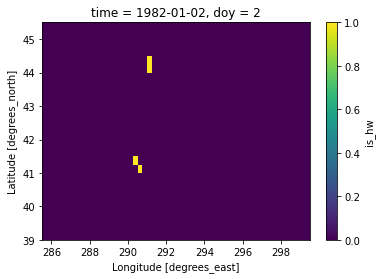

In [4]:
# Visual check
events_ds.isel(time = 1).is_hw.plot()

---

# Chat GPT Solution to MHW event tracking

The solutions provided in the previous answers assume that you're working with a single event at each location, and it might not handle multiple events at the same location correctly. To handle multiple events at a location, you would need to modify the code to track and differentiate between distinct events. Here's a revised approach to handle multiple events:

Flagging Exceedances Based on Threshold:

This part remains the same as before. You flag cases where data exceeds the threshold:

### Identifying Multiple Consecutive Instances:

To track multiple events, you can use the cumsum method in a way that distinguishes different events by using a combination of the location and threshold exceedance as identifiers:

In [10]:
import pandas as pd
exceedance_flags = events_ds.is_hw.drop("doy")
exceedance_flags

<xarray.DataArray 'is_hw' (time: 14975, lat: 26, lon: 56)>
[21803600 values with dtype=bool]
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2022-12-31T12:00:00
  * lat      (lat) float32 39.12 39.38 39.62 39.88 ... 44.62 44.88 45.12 45.38
  * lon      (lon) float32 285.6 285.9 286.1 286.4 ... 298.6 298.9 299.1 299.4

In [19]:


# Convert the flag data to a pandas DataFrame
df = exceedance_flags.to_dataframe().reset_index()
#df

# Group by cell position and threshold exceedance to calculate the cumulative sum
# This will create unique labels for different events at each cell
group_labels = df.groupby(['lat', 'lon', df['is_hw'].eq(1).cumsum()])['time']#.cumsum()
group_labels.head()

0          1982-01-01 00:00:00
1          1982-01-01 00:00:00
2          1982-01-01 00:00:00
3          1982-01-01 00:00:00
4          1982-01-01 00:00:00
                   ...        
21803595   2022-12-31 12:00:00
21803596   2022-12-31 12:00:00
21803597   2022-12-31 12:00:00
21803598   2022-12-31 12:00:00
21803599   2022-12-31 12:00:00
Name: time, Length: 20032330, dtype: datetime64[ns]

### Filtering Instances Based on Duration:

You can continue with the same code for filtering instances based on the duration:

In [18]:
# Define minimum and maximum duration criteria
min_duration = 5
max_duration = 3

# Find the first day of each instance
instance_start = df.groupby(['lat', 'lon', group_labels])['time'].first()

# Find the last day of each instance
instance_end = df.groupby(['lat', 'lon', group_labels])['time'].last()

# Calculate the duration of each instance
instance_duration = (instance_end - instance_start).dt.days + 1

# Filter instances that meet the duration criteria
valid_instances = instance_duration.between(min_duration, max_duration)

ValueError: Grouper for '<class 'pandas.core.groupby.generic.DataFrameGroupBy'>' not 1-dimensional

### Creating the Resulting Dataset:

The code for creating the resulting xarray dataset also remains the same:

In [ ]:
# Create an xarray dataset with the same dimensions as your data
ds_result = xr.Dataset(
    {
        "above_threshold": (["time", "latitude", "longitude"], np.empty((len(times), len(latitudes), len(longitudes))),
    },
    coords={"time": times, "latitude": latitudes, "longitude": longitudes},
)

# Fill the dataset with NaN
ds_result["above_threshold"][:] = np.nan

# Mark True values for valid instances
ds_result["above_threshold"] = valid_instances.values

# Replace NaN with False for instances that did not meet the conditions
ds_result["above_threshold"].where(ds_result["above_threshold"], False, inplace=True)

# Show the resulting xarray dataset
print(ds_result)

By using the cumsum method with both the latitude, longitude, and threshold exceedance as identifiers, you can distinguish between different events at each cell. This allows the code to handle multiple events at the same location.

# Next Steps: OCETRAC

Once heatwave events have been flagged (not just when daily temperatures exceed some threshold) we will have the beginning steps to track events spatially using the OCETRAC library. This library tracks events in time + space as clusters of pixels rather than discrete grid cells adding more context to the extreme events globally.